In [1]:
from defectlib import extract_bnfeatures_from_defect, train_svm_classifier, plot_tsne
import numpy as np

from defectlib import load_tensors
from defectlib import load_tensors_all
from defectlib import combine_shuffle_tensors, display_tensor, keras_transform, make_model, train_model
from defectlib import Config, remove_sn, remain_sn
from matplotlib import image
from IPython.display import Image
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import defectlib
import cv2
import os
import numpy as np

from bokeh.plotting import figure, output_notebook
output_notebook()
from bokeh.plotting import figure, show

%matplotlib inline

Using TensorFlow backend.


Loading BokehJS ...

__pre-trained google Inception-v3 deep learning model__

Convolution Neural Network主要是兩個部分組成

1. 特徵萃取層 (Convolution layers, activation, max or average pooling)
2. 分類層 (fully connected layers)

Transfer Learning 的方法則是利用google inception model訓練好的特徵萃取層來轉換原始圖片
(Inception-v3 model: 從2012年起利用ImageNet比賽的資料訓練進行訓練，1M照片/1000類別)

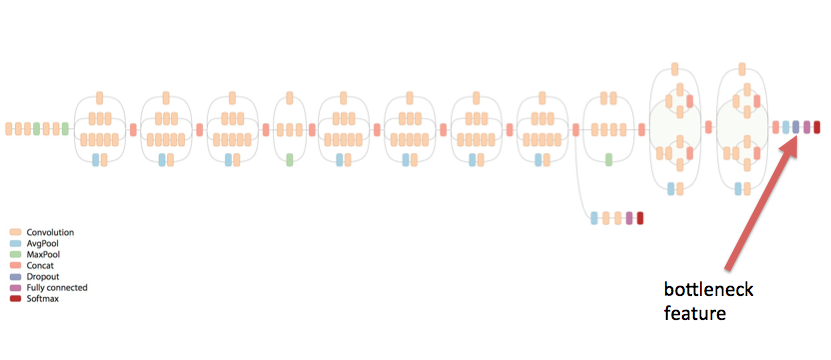

In [2]:
from IPython.display import Image, display
Image('images/07_inception_flowchart_bottleneck.png')

__Transfer Learning Flowchart__

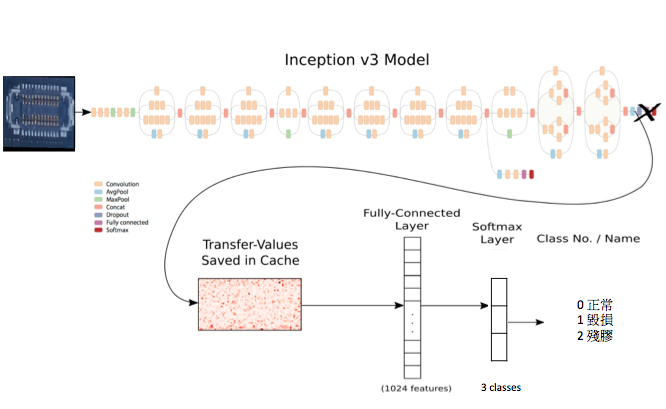

In [4]:
from IPython.display import Image, display
Image('images/defect_inception_nn.png')

In [5]:
# transfer leraning
from tensorflow.python.platform import gfile
def create_graph(model_path):
    with gfile.FastGFile(model_path, 'rb') as f:
        graph_def = tf.GraphDef()
        # parse read file with parseFro
        graph_def.ParseFromString(f.read())
        # Load teh Inception-V3 file
        _ = tf.import_graph_def(graph_def, name='')

In [6]:
def extract_bottleneck_features(list_images):
    '''extract buttleneck features from a list of images
    
    Notes:
        
    
    Args:
        list_images (list): a list of path_to_images
    
    Return:
        features (numpy array): an 2 dimensional numpy array,
                                each row represents a transformed feature of an image
        
    '''
    # set up the expected transformed feature number
    nb_features = 2048
    
    # initial feature numpy array
    features = np.empty((len(list_images),nb_features))
    
    labels = []
    
    # specified the inception model
    create_graph('./inception_dec_2015/tensorflow_inception_graph.pb')
    
    
    with tf.Session() as sess:
        
        # Get a reference to the pool_3 layer
        next_to_last_tensor = sess.graph.get_tensor_by_name('pool_3:0')
        #return next_to_last_tensor
        for ind, image in enumerate(list_images):
            if (ind%100 == 0):
                print('Processing %s...' % (image))
            if not gfile.Exists(image):
                tf.logging.fatal('File does not exist %s', image)

            image_data = gfile.FastGFile(image, 'rb').read()
            print type(image_data)
            print image_data.shape
            predictions = sess.run(next_to_last_tensor,
                {'DecodeJpeg/contents:0': image_data}
            )
            
            print predictions.shape
            
            features[ind,:] = np.squeeze(predictions)
            # labels.append(re.split('_\d+', image.split('/')[1])[0])
            # print labels

    return features

__利用google 訓練好的 inception model 將原始瑕疵影像轉換到2048維度 (embedding)__

In [7]:
features, labels, sns, images = extract_bnfeatures_from_defect('./ben1214/CL0401/', comb=True)

there are 26 images inside CL0401_2A_c0
Processing ./ben1214/CL0401/2A/CL0401_2A_c0/CL0401_Recombination_0_2A_0.jpg...
there are 60 images inside CL0401_2A_c1
Processing ./ben1214/CL0401/2A/CL0401_2A_c1/CL0401_Recombination_F3Y64830U17GY4TA_2A_0.jpg...
there are 207 images inside CL0401_2A_c4
Processing ./ben1214/CL0401/2A/CL0401_2A_c4/CL0401_Recombination_F3Y6452037UGY4TA_2A_0.jpg...
Processing ./ben1214/CL0401/2A/CL0401_2A_c4/CL0401_Recombination_F3Y65013JQKGY4TA_2A_5.jpg...
Processing ./ben1214/CL0401/2A/CL0401_2A_c4/CL0401_Recombination_F3Y65050P7DGY4RB_2A_3.jpg...
there are 29 images inside CL0401_6A_c0
Processing ./ben1214/CL0401/6A/CL0401_6A_c0/CL0401_Recombination_0_6A_0.jpg...
there are 36 images inside CL0401_6A_c4
Processing ./ben1214/CL0401/6A/CL0401_6A_c4/CL0401_Recombination_F3Y6452037UGY4TA_6A_0.jpg...
there are 39 images inside CL0401_6A_c7
Processing ./ben1214/CL0401/6A/CL0401_6A_c7/CL0401_Recombination_F3Y649617UMH3RPA_6A_0.jpg...
there are 19 images inside CL0401_8A_

In [8]:
features.shape

(448, 2048)

In [9]:
labels.shape

(448,)

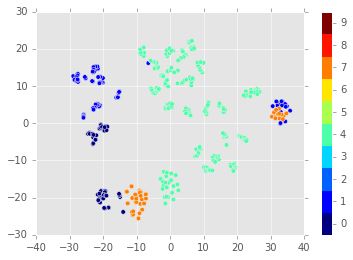

In [10]:
plot_tsne(features, labels, images, perplexity=20, interactive=False)

In [11]:
plot_tsne(features, labels, sns, perplexity=20, interactive=True, images=images)

__利用SVM以轉化後的bottleneck features建立分類模型__

In [13]:
train_svm_classifier(features, labels, sns, './model', split=True)

train test split == True
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] kernel=linear, C=1 ..............................................
[CV] ............... kernel=linear, C=1, score=0.973684, total=   0.2s
[CV] kernel=linear, C=1 ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ............... kernel=linear, C=1, score=0.955357, total=   0.2s
[CV] kernel=linear, C=1 ..............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV] ............... kernel=linear, C=1, score=0.981818, total=   0.3s
[CV] kernel=linear, C=10 .............................................
[CV] .............. kernel=linear, C=10, score=0.973684, total=   0.2s
[CV] kernel=linear, C=10 .............................................
[CV] .............. kernel=linear, C=10, score=0.955357, total=   0.2s
[CV] kernel=linear, C=10 .............................................
[CV] .............. kernel=linear, C=10, score=0.981818, total=   0.3s
[CV] kernel=linear, C=100 ............................................
[CV] ............. kernel=linear, C=100, score=0.973684, total=   0.2s
[CV] kernel=linear, C=100 ............................................
[CV] ............. kernel=linear, C=100, score=0.955357, total=   0.2s
[CV] kernel=linear, C=100 ............................................
[CV] ............. kernel=linear, C=100, score=0.981818, total=   0.3s
[CV] kernel=linear, C=1000 ...........................................
[CV] .

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   22.7s finished



Best parameters set:
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Confusion matrix:
Labels: 0,1,4,7

[[15  0  0  0]
 [ 0 23  0  0]
 [ 0  0 60  0]
 [ 0  0  0 14]]

Classification report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        15
          1       1.00      1.00      1.00        23
          4       1.00      1.00      1.00        60
          7       1.00      1.00      1.00        14

avg / total       1.00      1.00      1.00       112



GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'kernel': ['linear'], 'C': [1, 10, 100, 1000]}, {'kernel': ['rbf'], 'C': [1, 10, 100, 1000], 'gamma': [0.01, 0.001, 0.0001, 1e-05]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=3)